In [1]:
from __future__ import print_function, division, absolute_import

# Introduction to Parallel Computing - Targeting CPUs (in Python):

By Carl Fields (Los Alamos National Lab)

*This exercise was designed in part based on tutorials from the [Scipy 2017 workshop](https://github.com/gforsyth/numba_tutorial_scipy2017) and the Numba [Tutorials]((https://numba.readthedocs.io/en/stable/user/examples.html) Pages.* 

---

## Learning Objectives

- Using Numba decorators to speed up algorithms
- Using `timeit` profiler for generic algorithm profiling
- Creating complex alogrithms utilizing Numba decorators
- Using `line_profiler` to expose parallelizable regions in complex algorithms
- Creating Numpy Ufuncs
- Exploring shared memory parallelism in Numba
- Characterizing strong scaling 
---

## Problem 0) Creating Our HPC Environment
**Before** beginning, we want to prepare a new environment for the purpose of this exercise.

Run the following on the command line:

```linux
$ conda create --name hpc
$ conda activate hpc
```

After doing so, we want to install a few tools that will be needed for this notebook:

```linux
$ conda install -c conda-forge jupyter ipython numpy numba line_profiler matplotlib
```

---



We can check that our installation worked by trying to import the required libraries:

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib notebook

## Problem 1) Exploring a basic algorithm

We want to define a function first: we will use a function designed to compute the Hypotenuse of a right angle triangle.

A common problem with the straightforward implementation is the potential for arithmetic overflow when computing the sqaures. `Hypot` is an equivalent algorithm that aims to avoid this problem (https://en.wikipedia.org/wiki/Pythagorean_addition):

We want to solve $$c = x\sqrt{1+(t^2)}$$ given that $$x=|x|$$ and $$y=|y|$$ We also define $$t=min(|x|,|y|)$$ and $$x=max(|x|,|y|)$$ And lastly, defining $$t=t/x$$, we can solve our original equation avoiding [underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) or [overflow](https://en.wikipedia.org/wiki/Integer_overflow). 

**Problem 1a** Write your `Hypot` routine here:

In [4]:
# definition here https://en.wikipedia.org/wiki/Pythagorean_addition
def hypot(x, y):
    x = abs(x)
    y = abs(y)
    t = min(x,y)
    x = max(x,y)
    t = t/x
    return  x*np.sqrt(1 + t**2)

**Problem 1b** Run your `Hypot` routine for a triangle with side lengths of $$x=3$$ and $$y=5~.$$ 

Does the result make sense?

In [7]:
print(hypot(3,5))

5.8309518948453


Using `timeit` to measure performance


We want to start by exploring some options available for profiling or timing a given piece or code or routine. This will allow us to assess any potential areas of a code that might be performing slowly and/or expose a potentially parallelizable region. 

Lets start by considering [timeit- *Measure execution time of small code snippets* ](https://docs.python.org/3/library/timeit.html).

**Problem 1c** Run your `Hypot` routine here using the `timeit` preamble:

In [9]:
%timeit hypot(3,5)

1.11 µs ± 12.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Ok, what do the results mean? Is that fast? Is it efficient? We don't know yet. Let's try to start answering this question by leveraging the tools in `Numba`.

`Numba` *translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library. Numba-compiled numerical algorithms in Python can approach the speeds of C or FORTRAN.* Documentation can be found [here](https://numba.pydata.org/). 

One of the most straightforward ways to leverage `Numba` is to mark routines for optimization using the Just-In-Time compilation decorators. More details about this can be found [here](https://numba.readthedocs.io/en/stable/reference/jit-compilation.html#numba.jit).

In general, the `@jit` decorators will be added before the defintion of an algorithm. 

**Problem 1d** Write `Hypot` routine this time using the `@jit` decorator from numba:

In [17]:
import numba

@numba.njit
def hypot_numba(x, y):
    x = abs(x)
    y = abs(y)
    t = min(x,y)
    x = max(x,y)
    t = t/x
    return  x*np.sqrt(1 + t**2)

**Problem 1e** Compare your original routine to your new routine using Numba:


*Hint- Numba should be about 4 time faster!* You may have to run the Numba routine twice.

In [18]:
%timeit hypot_numba(3,5)

161 ns ± 1.57 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [ ]:
 # complete

## Problem 2) Exploring a complex algorithm

While the speedup we observe here is great. We can do even better. When optimizing algorithms, `Numba` will first attempt to use no Python. But if this fails, it will try again using Python. The fastest performance increase will be when the optimization can be made without Python. More details can be found [here](https://numba.pydata.org/numba-doc/latest/user/performance-tips.html). Next, we will consider a more complex algorithm and ensure the optimization is made without python. 

We will explore an example that highlights Numba's loop parallelization strengths. 


**Problem 2a** Run the following algorithm to compute the Mandelbrot set. Background on the algorithm can be found [here](https://en.wikipedia.org/wiki/Plotting_algorithms_for_the_Mandelbrot_set):

In [13]:
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

Run the acutal code here using the lines below. 

Note: changing the image dimension can significantly change the run time. The chosen values here can run in less than a minute for the unoptimized version. 

In [14]:
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

<IPython.core.display.Javascript object>


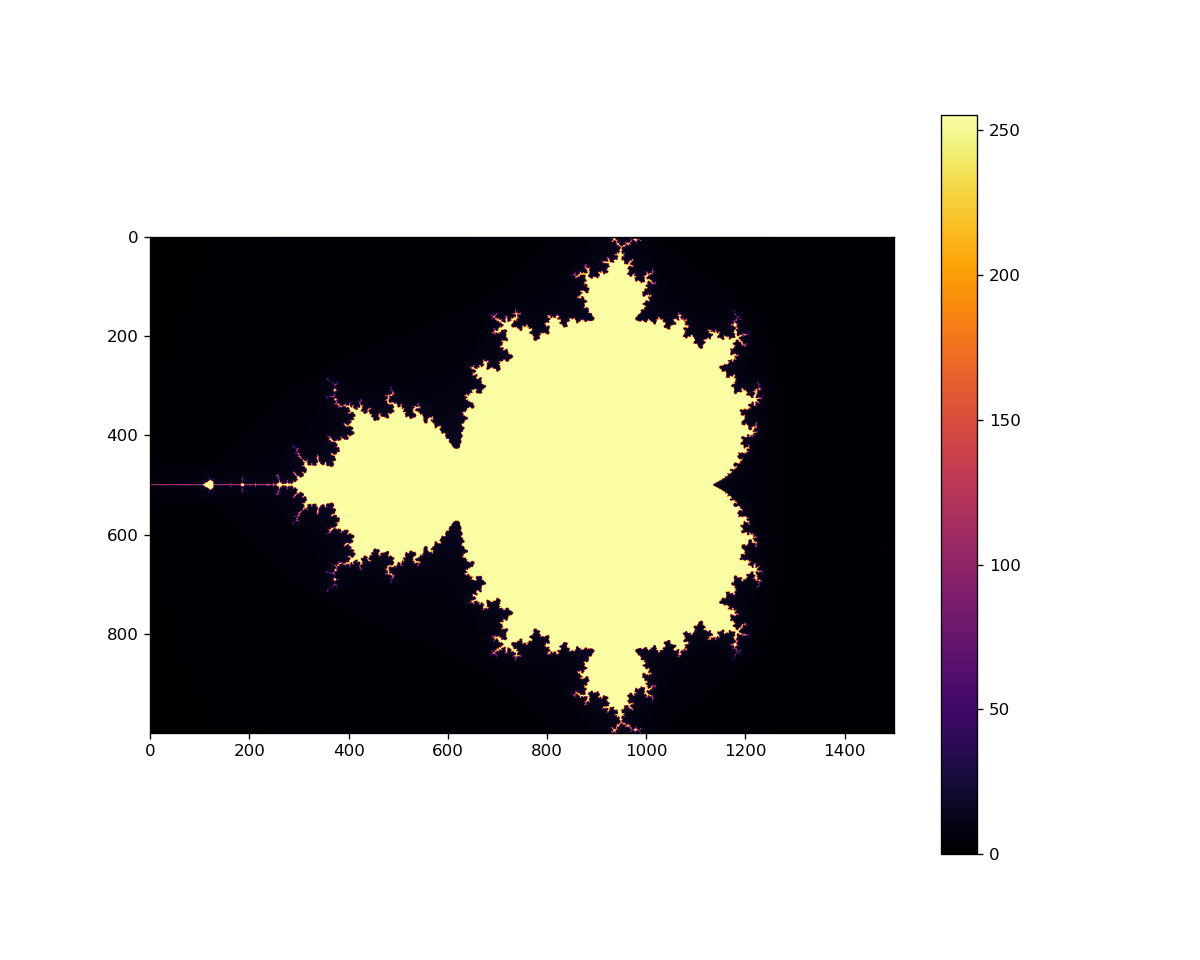

In [15]:
# plot the results - for fun!
plt.figure(figsize=(10,8))
plt.imshow(image, cmap='inferno')
plt.colorbar();

Before optimizing, lets deteremine the speed of the default algorithm. 
 
Note: timeit is a magic command part of those defined [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html)

Rerun our "program", the two image lines from before, using `timeit` for a cell.  

In [24]:
%%timeit
image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
image = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)

3.64 s ± 62.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Problem 2b** Rewrite and time the Mendelbrot routines using Numba decorators specifying no python:

Note: the `@njit` decorator is equivalent to `@jit(nopython=True)`.

In [25]:
# complete

@numba.njit
def mandel_numba(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255

@numba.njit
def create_fractal_numba(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x] = color

    return image

Use the `timeit` tool again to see if you obtained a speedup.

Hint: You should see a speedup!

In [28]:
%%timeit
image_numba = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
image_numba = create_fractal_numba(-2.0, 1.0, -1.0, 1.0, image, 20)

39 ms ± 625 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Question**: What is going on? What is Numba doing and why is this example so much faster than our `Hypot` example?
    
**Answer**: Numba reads the Python bytecode for a decorated function and combines this with information about the types of the input arguments to the function. It analyzes and optimizes your code, and finally uses the LLVM compiler library to generate a machine code version of your function, **targeted to your CPU** capabilities. This compiled version is then used every time your function is called.    

Numba excels with 
- loops
- fastmath
- linear algebra

read more about these performance tips [here](https://numba.pydata.org/numba-doc/latest/user/performance-tips.html#performance-tips). 

We benefitted from significant speedup in Problem 2 in part by being able to parallelize the nested loop in `create_fractal`.
    

## Problem 3) Exposing parallelization in complex programs: Cavity Flow
Now, lets consider a "program" or set of instructions that take place perform a given task. 

The following example is based on the Cavity Flow example as part of [Scipy 2017](https://github.com/gforsyth/numba_tutorial_scipy2017/blob/master/notebooks/05.1.Cavity_Flow.ipynb).

The two-dimensional (2D) lid-driven cavity is a well-known benchmark problem for viscous incompressible fluid flow. The problem describes a rectangular cavity with constant velocity at the lid. The resulting velocity field shows a signiture spiral flow pattern with two pressure deficits. We will be interested in solving the pressure field. 

![CavityFlow](https://j.gifs.com/vnJ88M.gif)

The pressure field is given by the Poisson equation, an [elliptic PDE](https://en.wikipedia.org/wiki/Elliptic_partial_differential_equation) with a solution of the form:

**Equation 1**
$$
\begin{align}
    p_{i,j}^{n+1} &= \frac{1}{4}\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}+p_{i,j+1}^{n}+p_{i,j-1}^{n}\right)\\\\
    &-\frac{\rho \Delta x}{16} \left( \frac{2}{\Delta t} \left(u_{i+1,j} - u_{i-1,j} + v_{i,j+1} - v_{i,j-1}\right) \right . \\\\
    &-\frac{2}{\Delta x}\left(u_{i,j+1} - u_{i,j-1} \right) \left(v_{i+1,j} - v_{i-1,j} \right) \\\\
    &- \left . \frac{\left(u_{i+1,j} - u_{i-1,j} \right)^2}{\Delta x}
    - \frac{ \left(v_{i,j+1} - v_{i,j-1} \right)^2 }{\Delta x} \right)\\\\
   \end{align} 
$$

We will start by writing out the terms of Equation 1. This has been done for you. 

In [29]:
# solves the velocity terms of Eqn 1. 
def velocity_term(b, rho, dt, u, v, dx):
    b[1:-1, 1:-1] = (
        rho * dx / 16 * 
        (2 / dt * (u[2:, 1:-1] - 
                   u[:-2, 1:-1] + 
                   v[1:-1, 2:] - 
                   v[1:-1, :-2]) - 
        2 / dx * (u[1:-1, 2:] - u[1:-1, :-2]) *
                 (v[2:, 1:-1] - v[:-2, 1:-1]) - 
        (u[2:, 1:-1] - u[:-2, 1:-1])**2 / dx - 
        (v[1:-1, 2:] - v[1:-1, :-2])**2 / dx)
                     )

    return b

In [30]:
# solves the first term of Eqn 1. 
def pressure_poisson(p, b, l2_target):
    iter_diff = l2_target + 1
    n = 0
    while iter_diff > l2_target and n <= 500:

        pn = p.copy()
        p[1:-1,1:-1] = (.25 * (pn[2:, 1:-1] +
                               pn[:-2, 1:-1] +
                               pn[1:-1, 2:] +
                               pn[1:-1, :-2]) -
                               b[1:-1, 1:-1])

        p[:, 0] = p[:, 1]   #dp/dy = 0 at y = 0
        p[:, -1] = 0        #p = 0 at y = 2
        p[0, :] = p[1, :]   #dp/dx = 0 at x = 0
        p[-1, :] = p[-2, :] #dp/dy = 0 at x = 2
      
        
        if n % 10 == 0:
            iter_diff = np.sqrt(np.sum((p - pn)**2)/np.sum(pn**2))
                    
        n += 1
        
    return p

Next, to help alleviate hard coding and to focus on optimatization, we will load a file `ns_helper` that contains the additional information for the Cavity Flow problem and solution to the [Navier-Stokes equations](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations#Stream_function_for_incompressible_2D_fluid) using finite-difference methods (https://en.wikipedia.org/wiki/Finite_difference_method).

In [31]:
import ns_helper

We will also want to import initial condition for the velocity field. We will utilize [pickle](https://docs.python.org/3/library/pickle.html). `pickle` examples can be found [here](https://docs.python.org/3/library/pickle.html#examples). Our initial data live in `IC.pickle`.

In [32]:
import pickle

**Problem 3a** Write your program to use the necessary pieces to solve the equation:

In [33]:
def run_cavity():
    nx = 41 # fixed to 41 
    ny = 41 # fixed to 41 
    with open('IC.pickle', 'rb') as f:
        u, v, p, b = pickle.load(f)

    dx = 2 / (nx - 1) 
    dt = .005 # < 0.1
    nt = 1000 #< 1000
    
    # call cavity flow here - view `ns_helper` to determine the required args and output
    return ns_helper.cavity_flow(u, v, p, nt, dt, dx, velocity_term, pressure_poisson, rho=1, nu=0.1, rtol=1e-3)
    

**Problem 3b** Call your program

In [35]:
u,v,p = run_cavity()
print(u)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  1.22327380e-05 -1.24767890e-04 ...  1.36532049e-01
   3.62224109e-01  1.00000000e+00]
 [ 0.00000000e+00 -3.74179733e-05 -3.95229185e-04 ...  2.21118217e-01
   4.87854441e-01  1.00000000e+00]
 ...
 [ 0.00000000e+00 -2.35917901e-05 -3.64780367e-04 ...  2.49115358e-01
   5.11032795e-01  1.00000000e+00]
 [ 0.00000000e+00  1.99376262e-05 -1.09219075e-04 ...  1.55572670e-01
   3.87436654e-01  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]


**Problem 3c** `ns_helper` also contains a helper function to plot the resulting pressure field - `quiver_plot`. Import this function and run it using the results of your program run:

In [ ]:
 # complete

In [ ]:
 # complete

*Hint: you should see something that looks like the gif from earlier, but with contours, quivers, and a better colormap!*

**Problem 3d** Now, we want to begin profiling our program and determining its speed. To do this, we will need to add additional steps. 

1. Run our magic `timeit` command. 

2. Load the `line_profiler` tool that we downloaded. This tool is described [here](https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/).

3. Run the `line_profiler` tool.

*Hint: you will want to use the magic command `lprun` with flags `-f main_program our_program()`*.

In this case, `main_program` would be the `cavity_flow` program we loaded from the helper file and `our_program` would be the program we defined in *Problem 3a*. 

Running `lprun` will bring up a diagnostic window describing our program. 

**Problem 3e** Analysis `lprun` window to identify the part of the program using the largest `% Time`. Guidance on interpreting `line_profile` diagnostics can be found [here](https://github.com/pyutils/line_profiler). Hint, it should be taking about 70% of total runtime. 

In [ ]:
 # complete

In [ ]:
 # complete

In [ ]:
 # complete

**Problem 3f** Speed up the slowest part of the program using Numba:

In [ ]:
 # complete

In [ ]:
 # complete
def pressure_poisson(p, b, l2_target):
    I, J = b.shape

    iter_diff = l2_target + 1

    n = 0
    while iter_diff > l2_target and n <= 500:
        pn = p.copy()
        for i in range(1, I - 1):
            for j in range(1, J - 1):
                p[i, j] = (.25 * (pn[i, j + 1] +
                                  pn[i, j - 1] +
                                  pn[i + 1, j] +
                                  pn[i - 1, j]) -
                                  b[i, j])

        for i in range(I):
            p[i, 0] = p[i, 1]
            p[i, -1] = 0

        for j in range(J):
            p[0, j] = p[1, j]
            p[-1, j] = p[-2, j]

        if n % 10 == 0:
            iter_diff = np.sqrt(np.sum((p - pn)**2)/np.sum(pn**2))

        n += 1

    return p

**Problem 3g** Call your program `run_cavity` with u,v,p array named differently to distinguish them from the unpotimized values. 

Note: Calling the program after redifining the slowest routine will replace the unoptimized but not if cells are executed out of order.

In [ ]:
 # complete

To ensure that our solution is equivalent to the unoptimized version (it should be). We can use the numpy all close function and compare `p` to `p_numba`, `u` to `u_numba` etc. Numpy all close is described [here](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html).

In [ ]:
 # complete
 # complete
 # complete

And just to be sure sure, plot the new data using `quiver_plot` again..

In [ ]:
 # complete

Finally, run our line_profile tool to see if we observed a speedup. 

Hint: we should!
    
Question: can you idenity any other regions that could be straightforwardly improved using Numba?

In [ ]:
 # complete

In [ ]:
 # complete

## Problem 4) Creating custom Numpy universal functions

*Numba’s vectorize allows Python functions taking scalar input arguments to be used as NumPy ufuncs. Creating a traditional NumPy ufunc is not not the most straightforward process and involves writing some C code. Numba makes this easy. Using the `vectorize()` decorator, Numba can compile a pure Python function into a ufunc that operates over NumPy arrays as fast as traditional ufuncs written in C.*

Documentation can be found [here](http://numba.pydata.org/numba-doc/0.17.0/user/vectorize.html#the-guvectorize-decorator).

**Problem 4a** Create arrays `x` and `y` and of dimensions 1000 by 1000 filled with random numbers.

In [ ]:
 # complete
 # complete

In [ ]:
def do_trig(x, y):
    z = np.sin(x**2) + np.cos(y)
    return z

**Problem 4b** Pass the created arrays to `do_trig` and time the results using `timeit`.

In [ ]:
original_time =  # complete

**Problem 4c** Use the `jit` decorator to see if we can speed up the `do_trig` routine. Time the results.

In [ ]:
 # complete
def do_trig_jit(x, y):
     # complete
     # complete

In [ ]:
jit_time =  # complete

**Question**: Is the `jit` version faster? Discuss. Do we expect it to? Recall where `Numba` excels. 

**Problem 4d** Use the `vectorize` decorator to see if we can speed up the `do_trig` routine. Also specifically target `parallel` optimization here. More details on targets can be found [here](https://numba.pydata.org/numba-doc/latest/reference/jit-compilation.html?highlight=vectorize%20target#numba.vectorize).

Hint: you will need to know the data types of the input arrays `x` and `y`. 

In [ ]:
 # complete

In [ ]:
 # complete

 # complete
def do_trig_vec(x, y):
     # complete
     # complete

**Problem 4e** Once your new function is created. We want to perform a scaling study to determine how well it performs to the previous versions. First, use `Numba`'s `set_num_threads` and set the number to 1. Time the result and compare. 

In [ ]:
 # complete

In [ ]:
 # complete

In [ ]:
 # complete

**Problem 4f** 

**Question:** Discuss your results. Is it slower or faster? 

**Answer:** With one thread, it should be slower. We are currently not leveraging the multiple threads on our CPU and actually just spending cycles creating and destroying threads in our routine. 

**Problem 4g** Now, run the vectorized and parallel version of our function for `1,2,4` (and if your machine supports it `8` threads). Record the timing results for each and plot the number of threads vs. average completion time produced by `timeit`.

*Note:  Typically OpenMP threads are usually limited to  2 times or times the number of cores of the CPU on a single CPU machine.* 

In [ ]:
 # complete
 # complete

In [ ]:
 # complete
 # complete

In [ ]:
 # complete
 # complete

In [ ]:
threads = np.array([1,2,4,
                     # complete])

timing = np.array([ # complete
                    ])

In [ ]:
%matplotlib inline

In [ ]:
 # complete
plt.xlabel('Number of OMP Threads')
plt.ylabel('Average completion time')
plt.show()

**Problem 4h** Lastly, plot the Speedup $$S_{p}= T_{1}/T_{p}$$ where $p$ is the number of threads used in this case.

In [ ]:
 # complete
plt.xlabel('Number of OMP Threads')
plt.ylabel('Speedup')
plt.show()

**Question:** Ideal scaling would be a straight line: 

$$S_{p}=T_{1}/p$$

How does your results compare? Do you think this could change with problem size?

**Answer:** Larger arrays might benefit more but theres a limit!

## Problem 5) Revisiting The Cavity Problem (Optional)

**Problem 5a** Rewrite the two most expensive parts of the Cavity problem and compare the speedup to the original non-Numba routine runtime. 

Hint: You may want to utilize the `@vectorize` decorator and other flags we have utilized so far in this lesson!